<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_03_cnns/CNN_Keras_example2_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de Redes Neurais Convolucionais (*Convolutional Neural Networks - CNN*)

**Disciplina**: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

Aula 03: CNNs

**Exemplo 02**: Comparando modelos densos e CNNs no problema MNIST

---


#1 - Selecionar o conjunto de dados MNIST

Iremos trabalhar com um conjunto de dados (*dataset*) composto por imagens. O dataset selecionado para esse exemplo é o [MNIST](http://yann.lecun.com/exdb/mnist/). Este dataset é composto por um total de 70 mil imagens,  onde cada imagem representa um dígito (de 0 a 9) escrito a mão. Logo, a tarefa é reconhecer qual é o dígito de acordo com imagem fornecida.



In [ ]:
# Caso o pacote keras não exista, ele será instalado
mat = installed.packages("keras")  #lista todos os pacotes instalados no ambiente
if(!"keras" %in% rownames(mat)) {
  install.packages("keras")        #instala se ele nao tiver sido instalado anteriormente
}

# Carregando o pacote keras para R
library("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [4]:
# carregando o dataset MNIST via keras (ele já existe dentro do pacote)
mnist = keras::dataset_mnist()

Loaded Tensorflow version 2.7.0



Dentro do pacote *keras* já temos o dataset MINST pré-carregado. Ele possui a mesma estrutura do dataset CIFAR-10 que usamos no exemplo anterior. Assim, dentro variável ```mnist``` teremos quatro conjuntos de dados:
* ```train$x```: conjunto de treinamento e seus respectivos atributos descritivos (pixels de cada imagem);
* ```test$y```: labels do conjunto de treinamento;
* ```train$x```: conjunto de teste e seus respectivos atributos descritivos;
* ```test$y```: labels do conjunto de teste.

Os conjuntos 'x' são arrays de imagens em preto e branco, de tamanho 28x28. Já os conjuntos 'y' são arrays categóricos com valores de 0-9.

In [5]:
# exemplos do conjunto de treinamento
x_train = mnist$train$x
# rotulos do conjunto de treinamento
y_train = mnist$train$y
# exemplos do conjunto de teste
x_test  = mnist$test$x
# rotulos do conjunto de teste
y_test  = mnist$test$y

# 2. Visualizar e investigar um pouco dos nossos dados

Inicialmente podemos checar a dimensão dos conjuntos que definimos acima:

In [6]:
# verificando a dimensao dos nossos conjuntos de dados (treino e teste)
cat("* Dimensoes do conjunto de treinamento:", dim(x_train), "\n")
cat("* Dimensoes dos rotulos de treinamento:", dim(y_train), "\n")
cat("* Dimensoes do conjunto de teste:", dim(x_test), "\n")
cat("* Dimensoes dos rotulos de teste:", dim(y_test), "\n")

* Dimensoes do conjunto de treinamento: 60000 28 28 
* Dimensoes dos rotulos de treinamento: 60000 
* Dimensoes do conjunto de teste: 10000 28 28 
* Dimensoes dos rotulos de teste: 10000 


Porque não dar uma olhada nessas imagens? Assim podemos ter uma real noção de como são nossos exemplos. Vamos plotar alguns dos exemplos de treinamento, e respectivas classes.


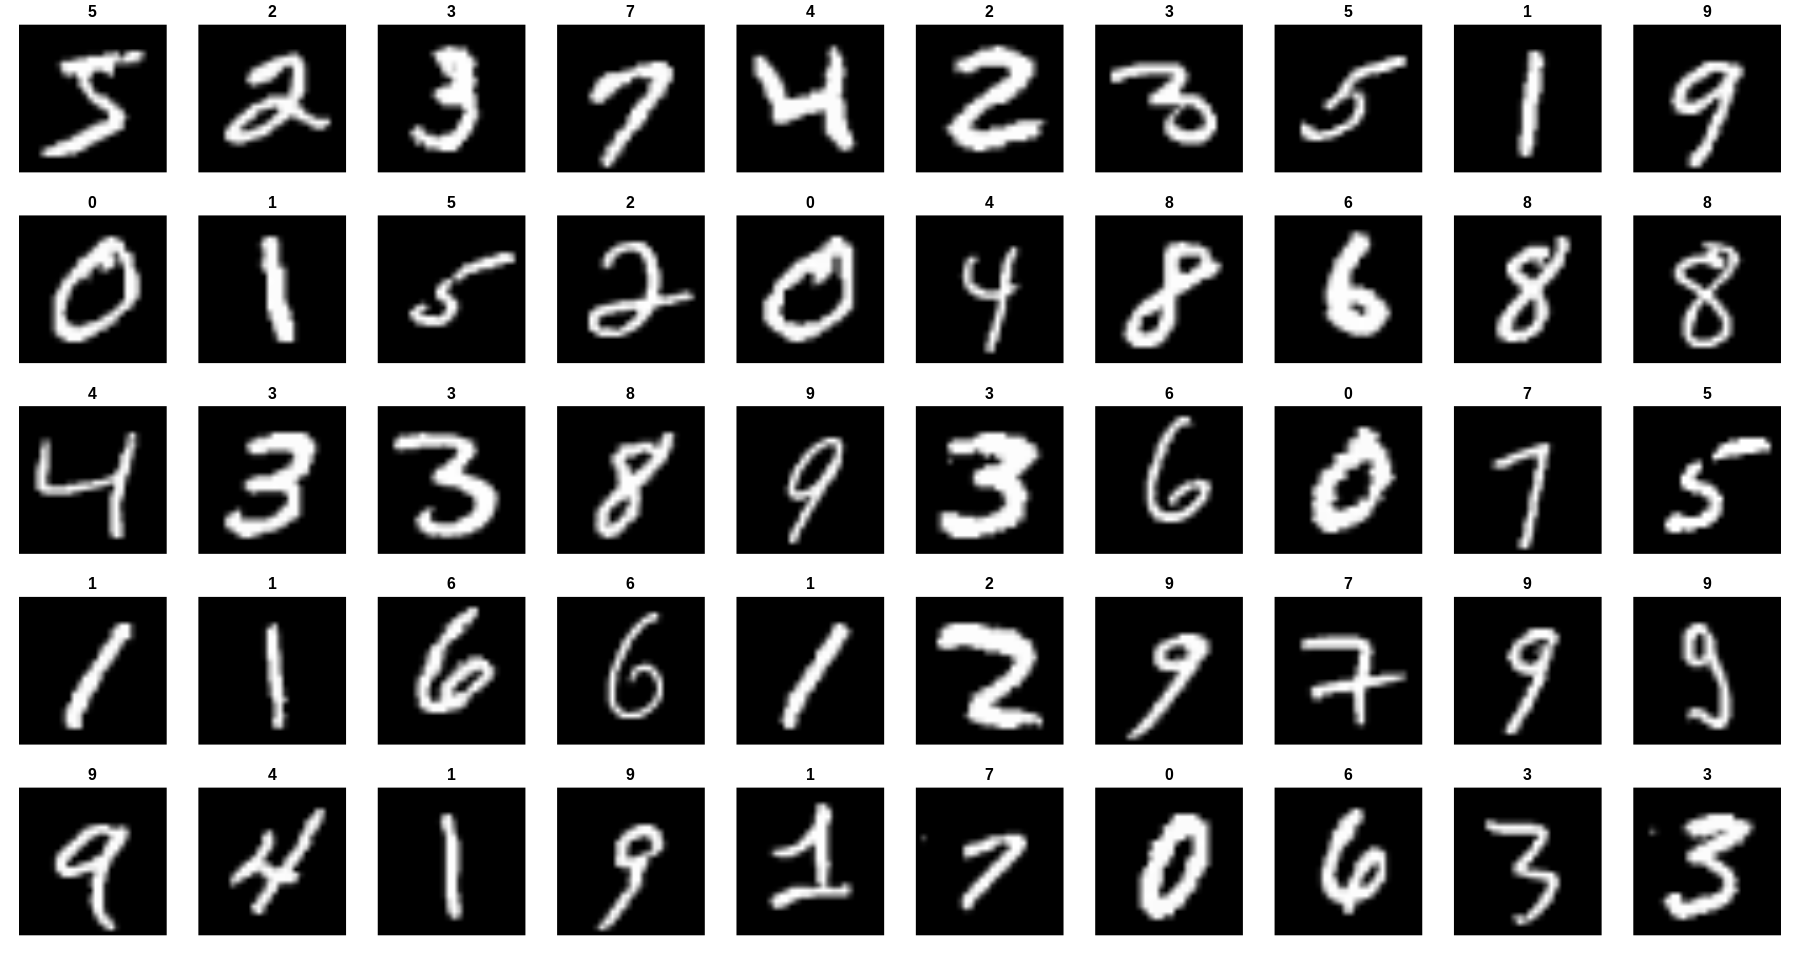

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
index = 1:50

# e as mostraremos em um grid 5 x 6 - 5 linhas, 6 colunas
par(mfcol = c(5,10), mar = rep(1, 4), oma = rep(0.2, 4))
x_train[index,,] %>% 
  purrr::array_tree(1) %>%
  purrr::set_names(y_train[index]) %>% 
  purrr::map(as.raster, max = 255) %>%
  purrr::iwalk(~{plot(.x); title(.y)})

Como dito anteriormente, teremos 10 classes, uma para cada dígito de 0-9. Podemos ir além, e verificar se o problema é balanceado ou desbalanceado por meio da distribuição das classes, tanto no treino como no teste:

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



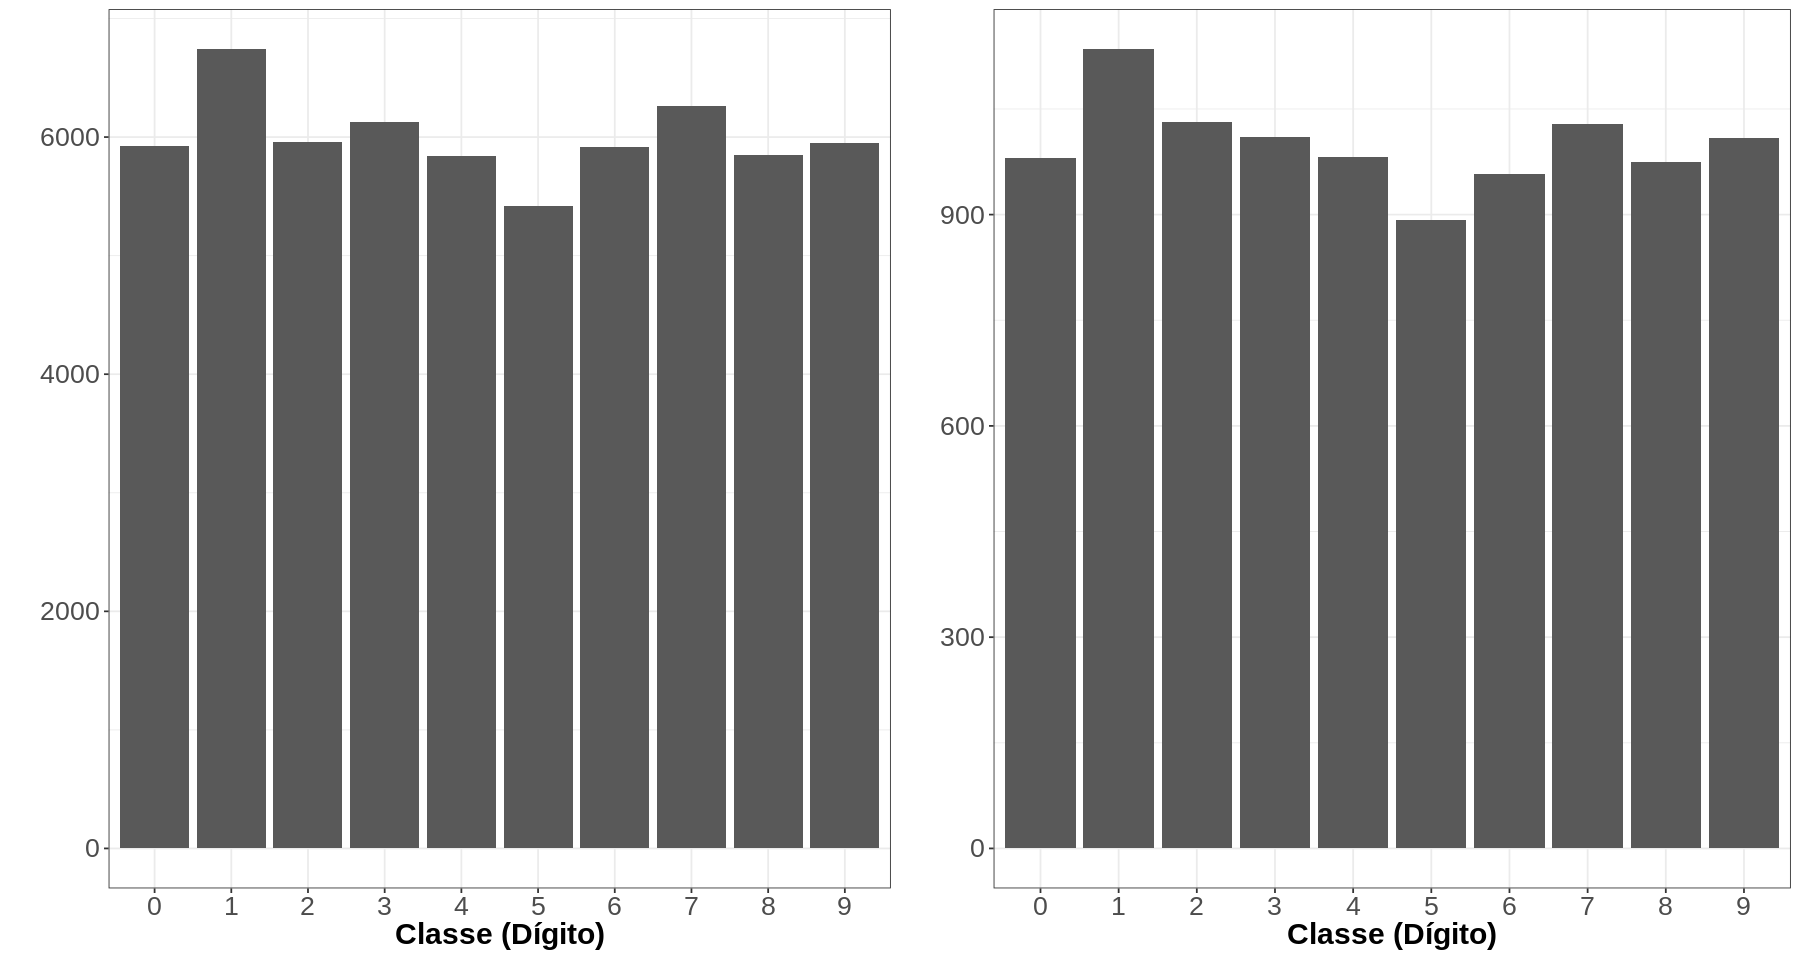

In [12]:
# gráfico com a distribuição das classes
library('ggplot2')

if(!"gridExtra" %in% rownames(mat)) {
  install.packages("gridExtra")        #instala se ele nao tiver sido instalado anteriormente
}
library('gridExtra')

# histograma das classes no conjunto de treinamento
q1 = qplot(as.factor(y_train)) + theme_bw() + xlab("Classe (Dígito)")
q1 = q1 + theme(axis.text=element_text(size=16),
        axis.title=element_text(size=18,face="bold"))

# histograma das classes no conjunto de teste
q2 = qplot(as.factor(y_test)) + theme_bw() + xlab("Classe (Dígito)")
q2 = q2 + theme(axis.text=element_text(size=16),
        axis.title=element_text(size=18,face="bold"))

# plot duplo (treino - teste)
options(repr.plot.width=15, repr.plot.height=8)
gridExtra::grid.arrange(q1, q2, ncol=2)

Em ambos os cojuntos temos a mesma distribuição de classes, as proporções são mantidas. Além disso, não existe um *desequilíbrio* entre as classes. Assim, nossos conjuntos já estão bem amostrados para a realização dos experimentos.


# 3. Definir o setup experimental

Vamos definir algumas variáveis para nos ajudar durante a execução do algoritmo:

In [13]:
# vamos realizar treinamento em batch (blocos de entradas) e não online (a cada instância)
batch_size = 128

# numero de classes do problema
num_classes = 10

# numero de epocas que iremos treinar o algoritmo
epochs = 12

# Dimensoes das imagem de entrada
img_rows = 28
img_cols = 28

Além disso, vamos reorganizar nossos dados (```array_shape```) e transformar os valores dos pixels em números reais no intervalo [0,1].

In [14]:
# definindo as dimensoes do conjunto de treinamento -> array de (60k, 28, 28, 1)
x_train = array_reshape(x_train, c(nrow(x_train), img_rows, img_cols, 1))

# definindo as dimensoes do conjunto de teste -> array de (10k, 28, 28, 1)
x_test  = array_reshape(x_test, c(nrow(x_test), img_rows, img_cols, 1))

# dimensoes de uma imagem
input_shape = c(img_rows, img_cols, 1)

In [15]:
# Transformar os pixels de RGB para um numero no intervalo [0,1]
x_train = x_train / 255
x_test  = x_test / 255

cat('x_train_shape:', dim(x_train), '\n')
cat(nrow(x_train), 'train samples\n')
cat(nrow(x_test), 'test samples\n')

# Converter classe para matrizes binárias 
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

cat('x_train classes\n')
print(head(y_train))
cat('x_test classes\n')
print(head(y_test))


x_train_shape: 60000 28 28 1 
60000 train samples
10000 test samples
x_train classes
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]    0    0    0    0    0    1    0    0    0     0
[2,]    1    0    0    0    0    0    0    0    0     0
[3,]    0    0    0    0    1    0    0    0    0     0
[4,]    0    1    0    0    0    0    0    0    0     0
[5,]    0    0    0    0    0    0    0    0    0     1
[6,]    0    0    1    0    0    0    0    0    0     0
x_test classes
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]    0    0    0    0    0    0    0    1    0     0
[2,]    0    0    1    0    0    0    0    0    0     0
[3,]    0    1    0    0    0    0    0    0    0     0
[4,]    1    0    0    0    0    0    0    0    0     0
[5,]    0    0    0    0    1    0    0    0    0     0
[6,]    0    1    0    0    0    0    0    0    0     0


#3 - Criando um modelo de CNN

Vamos inicializar o nosso modelo de CNN com uma arquitetura composta por:
1.   C1 - 1a Camada Convolucional, com 32 filtros, kernel (3x3) função de ativação do tipo ReLU
2.   C2 - 2a Camada Convolucional, com 64 filtros, kernel (3,3), função de ativação ReLU
3.   P1 - 1a Camada de Polling, agregação pelo máximo, kernel (2,2)
4.   D1 - Droput (p = 25%), com probabilidade de 25% de *desligar* qualquer neurônio
5.   F - Flatten, achatando o sinal de 3 dimensões para 1 (vertor de números reais)
6.   D1 - 1a Camada Densa, com 128 neurônios, função de ativação ReLU
7.   Dr - Droput(p = 50%), probabilidade de 50% de *delsigar* qualquer neurônio
8.   D2 - 2a Camada Densa, camada de saída, com 10 neurônios (um para cada classe), e função de ativação softmax (logística) para retornar probablilidades 

In [16]:
# Define model
# pipe (%>%) operator
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = 'relu', input_shape = input_shape) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = num_classes, activation = 'softmax')

In [18]:
# Imprimindo nosso modelo (verificando a topologia)
print(model)

Model
Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_1 (Conv2D)                  (None, 26, 26, 32)              320         
                                                                                
 conv2d (Conv2D)                    (None, 24, 24, 64)              18496       
                                                                                
 max_pooling2d (MaxPooling2D)       (None, 12, 12, 64)              0           
                                                                                
 dropout_1 (Dropout)                (None, 12, 12, 64)              0           
                                                                                
 flatten (Flatten)                  (None, 9216)                    0           
                                                                                
 d

Uma vez criado o nosso modelo inicial (não-treinado), precisamos especificar as opções para realizar o **treinamento** da CNN. Para isso, vamos escolher três parâmetros:
*     ```optimizer``` - escolha de um algoritmo de treinamento (adam, sgd, ...). Aqui vamos testar o [AdaDelta](https://keras.io/api/optimizers/adadelta/);
*     ```loss``` - escolher uma medida de erro para ser minizada durante o treinamento. Nossa escolha é a medida de [entropia cruzada categórica](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class);
*     ```metrics``` - uma (ou mais) medida(s) de desempenho para avaliar as predições do modelo considerando o conjunto de teste. Vamos avaliar o modelo com base na acurácia.

In [19]:
# Compile model
model %>% compile(
  loss = loss_categorical_crossentropy,
  optimizer = optimizer_adadelta(),
  metrics = c('accuracy')
)

Próximo passo: treinar o modelo !

In [20]:
# Train model
history <- model %>% fit(
  x_train, y_train,
  batch_size = batch_size,
  epochs = epochs,
  validation_split = 0.2
)

E uma vez treinado, verificar a convergência do algoritmo no número de épocas que definimos (12):

`geom_smooth()` using formula 'y ~ x'



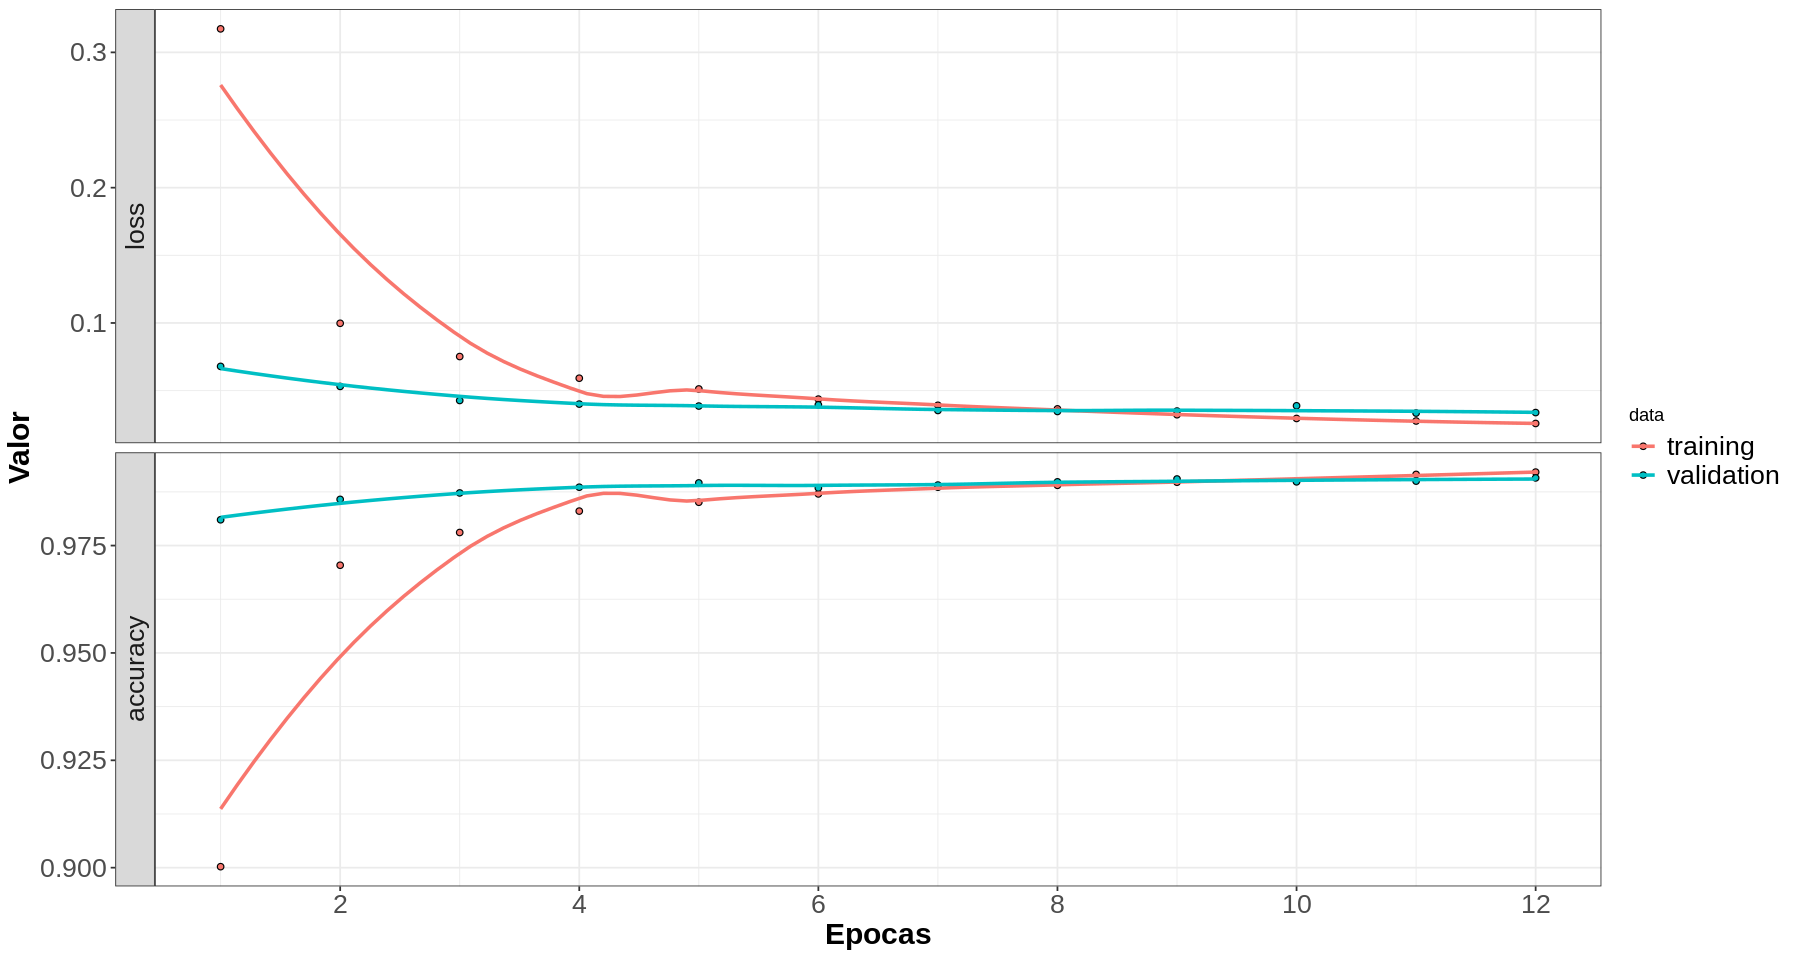

In [25]:
# plotando a curva de convergência do algoritmo
options(repr.plot.width=15, repr.plot.height=8, repr.size = 5)
g = plot(history) + ggplot2::theme_bw() + xlab("Epocas") + ylab("Valor")
g = g + theme(axis.text=element_text(size=16),
        axis.title=element_text(size=18,face="bold"),
        legend.text=element_text(size=16),
        strip.text = element_text(size = 16))
g

Com o modelo treinado, realizamos predicções no conjunto de treinamento e verificamos o desempenho real do algorimto:

In [26]:
scores <- model %>% evaluate(
  x_test, y_test, verbose = 0
)

# Output metrics
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.02613932 
Test accuracy: 0.9919 


Conseguimos uma **acurácia de aprox 99.1** % !!! O que é muito bom, por sinal.

#4. Comparar com outro modelo

Vamos além um pouco nas análises, e tentar criar uma Deep Neural Network com camadas densas. Esse modelo será nosso baseline, para verificar se a CNN que obtemos é realmente precisa.

Nosso baseline denso terá a seguinte arquitetura/topologia:

1.   Flatten - camada de entrada achatando as imagens/sinais 3D para 1D
2.   D1 - 1a Camada densa com 128 unidades, função de ativação ReLU
3.    D1 - 2a Camada densa, camada de saída, com 10 neurônios e função de ativação logística


In [27]:
#modelo2 - rede densa (feed forward)
model2 <- keras_model_sequential() %>%
   layer_flatten(input_shape=c(28,28,1)) %>%
   layer_dense(units = 128, activation = 'relu')%>%
   layer_dense(units = num_classes, activation = 'softmax')

In [29]:
print(model2)

Model
Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten_1 (Flatten)                (None, 784)                     0           
                                                                                
 dense_3 (Dense)                    (None, 128)                     100480      
                                                                                
 dense_2 (Dense)                    (None, 10)                      1290        
                                                                                
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________________________________________________________________




Como fizemos anteriormente, vamos definir os mesmos parâmetros/opções para treinamento com o modelo 1:

In [30]:
# Compile model
model2 %>% compile(
  loss = loss_categorical_crossentropy,
  optimizer = optimizer_adadelta(),
  metrics = c('accuracy')
)

E realizamos o treinamento (também o mesmo setup):

In [31]:
history2 <- model2 %>% fit(
  x_train, y_train,
  batch_size = batch_size,
  epochs = epochs,
  validation_split = 0.2
)

Vamos ver então a converência do modelo 2 (rede densa):

`geom_smooth()` using formula 'y ~ x'



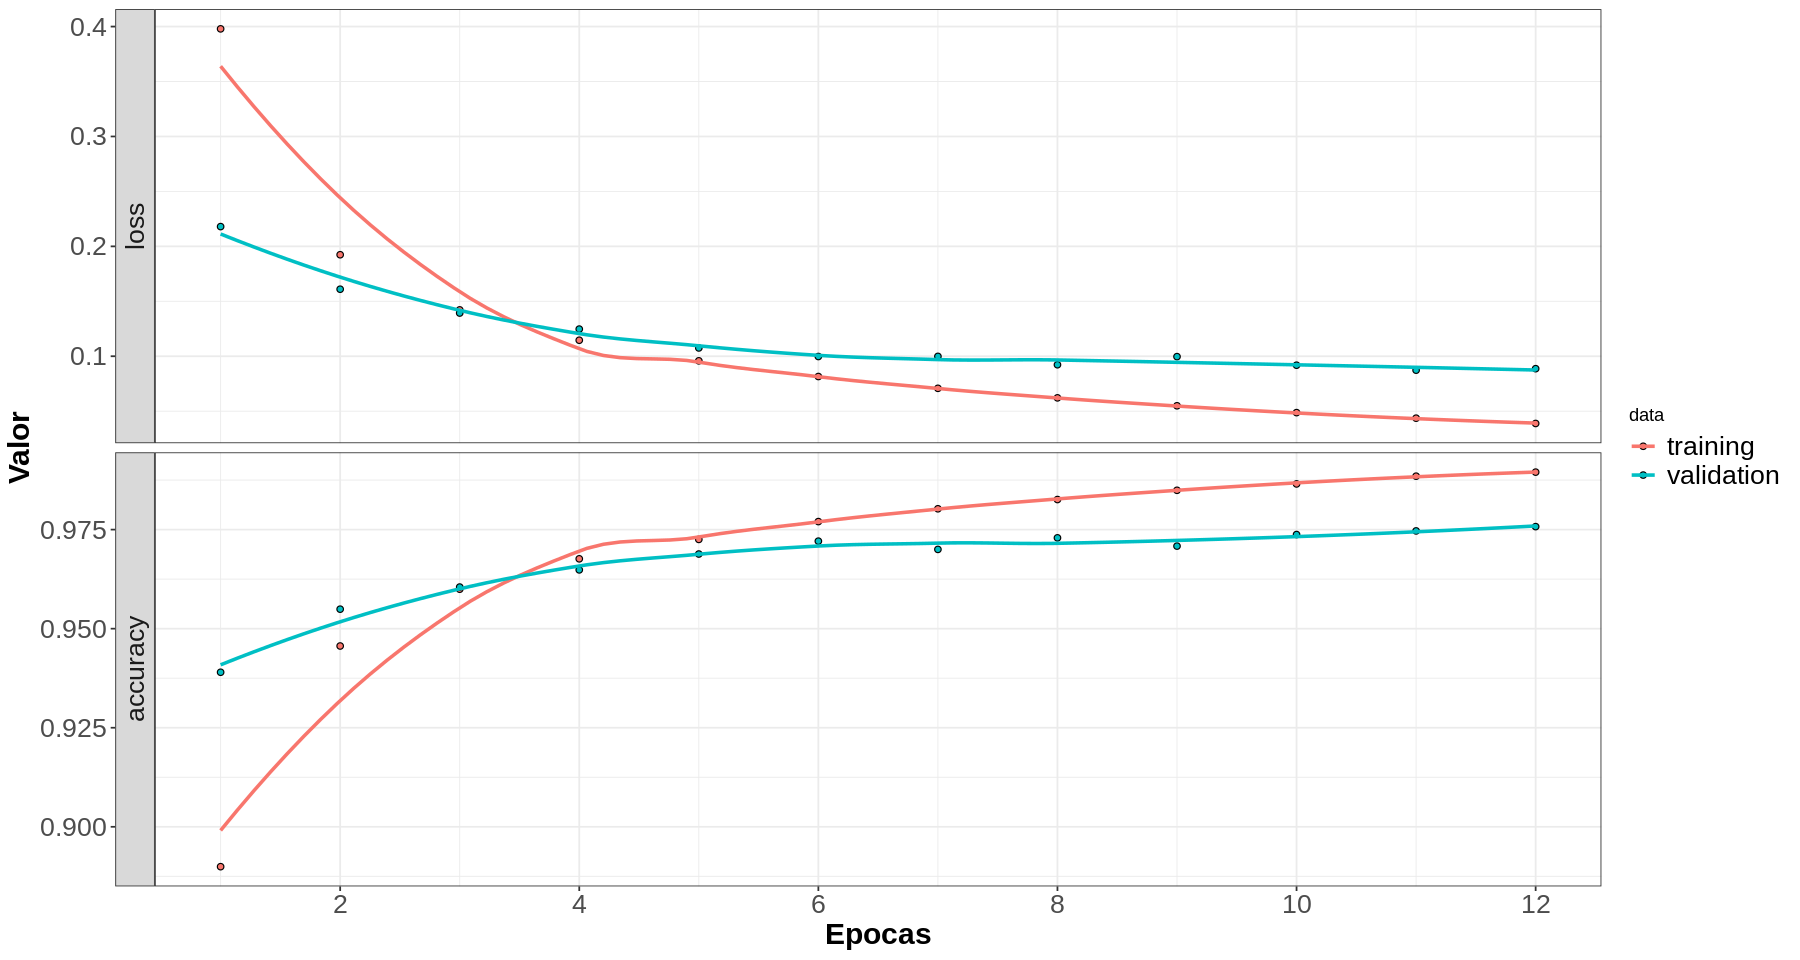

In [34]:
g2 = plot(history2) + ggplot2::theme_bw() + xlab("Epocas") + ylab("Valor")
g2 = g2 + theme(axis.text=element_text(size=16),
        axis.title=element_text(size=18,face="bold"),
        legend.text=element_text(size=16),
        strip.text = element_text(size = 16))
g2

E a acurácia no conjunto de testes:

In [35]:
scores2 <- model2 %>% evaluate(
  x_test, y_test, verbose = 0
)

# Output metrics
cat('Test loss:', scores2[[1]], '\n')
cat('Test accuracy:', scores2[[2]], '\n')

Test loss: 0.07698668 
Test accuracy: 0.976 


Aqui já temos uma diferença nas predições do conjunto de teste:
* CNN = 99.11%
* Rede densa = 97.6%

ou seja, a CNN consegue aprender melhor que uma rede *feedforward* simples (MLP).

Uma análise interessante de ser feita é comparar a convergência dos dois modelos que geramos (Densa e CNN). Lembrando que ambos os modelos possuem as mesmas configurações de dados e algoritmos de treinamento, o que muda são apenas
suas topologias (quantidade e tipos de camada). A informação da convergência dos modelos pode ser obtida das variáveis ```history```. 

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



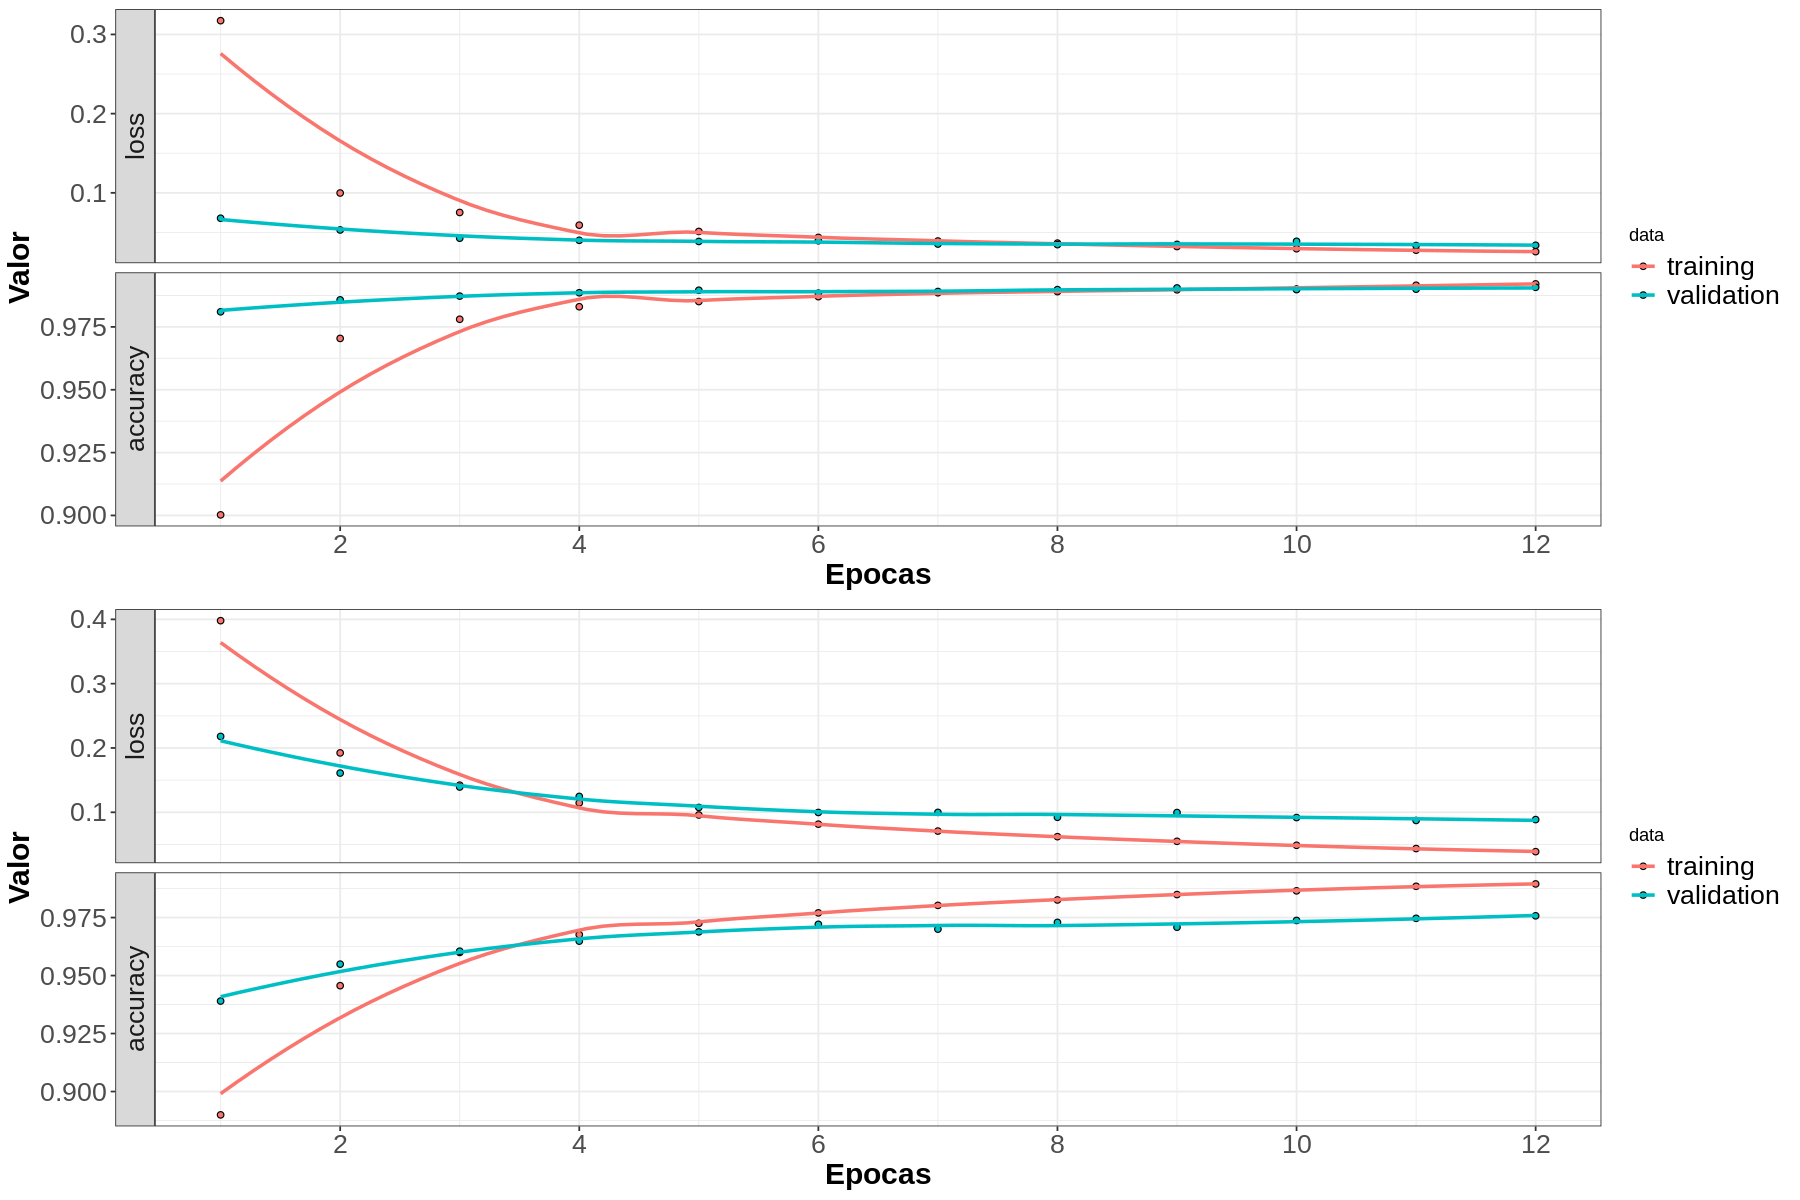

In [40]:
options(repr.plot.width=15, repr.plot.height=10)

#install.packages("gridExtra")
library(gridExtra)
gridExtra::grid.arrange(g, g2, nrow=2)


Há um indicativo de que a CNN converge mais rápido que o baseline, porém, vamos tentar deixar os dados em uma mesma escala:

In [41]:
# criando um data frame único com informação de treinamento dos dois modelos 
df1 = as.data.frame(history)
df1$model = "CNN"
df2 = as.data.frame(history2)
df2$model = "Dense"
df = rbind(df1, df2)
df$algo = paste(df$data, df$model, sep="-")

# vendo como ficou nosso df
head(df)


,epoch,value,metric,data,model,algo
,<int>,<dbl>,<fct>,<fct>,<chr>,<chr>
1,1,0.31736624,loss,training,CNN,training-CNN
2,2,0.09977477,loss,training,CNN,training-CNN
3,3,0.07519795,loss,training,CNN,training-CNN
4,4,0.05918654,loss,training,CNN,training-CNN
5,5,0.05125748,loss,training,CNN,training-CNN
6,6,0.04373766,loss,training,CNN,training-CNN


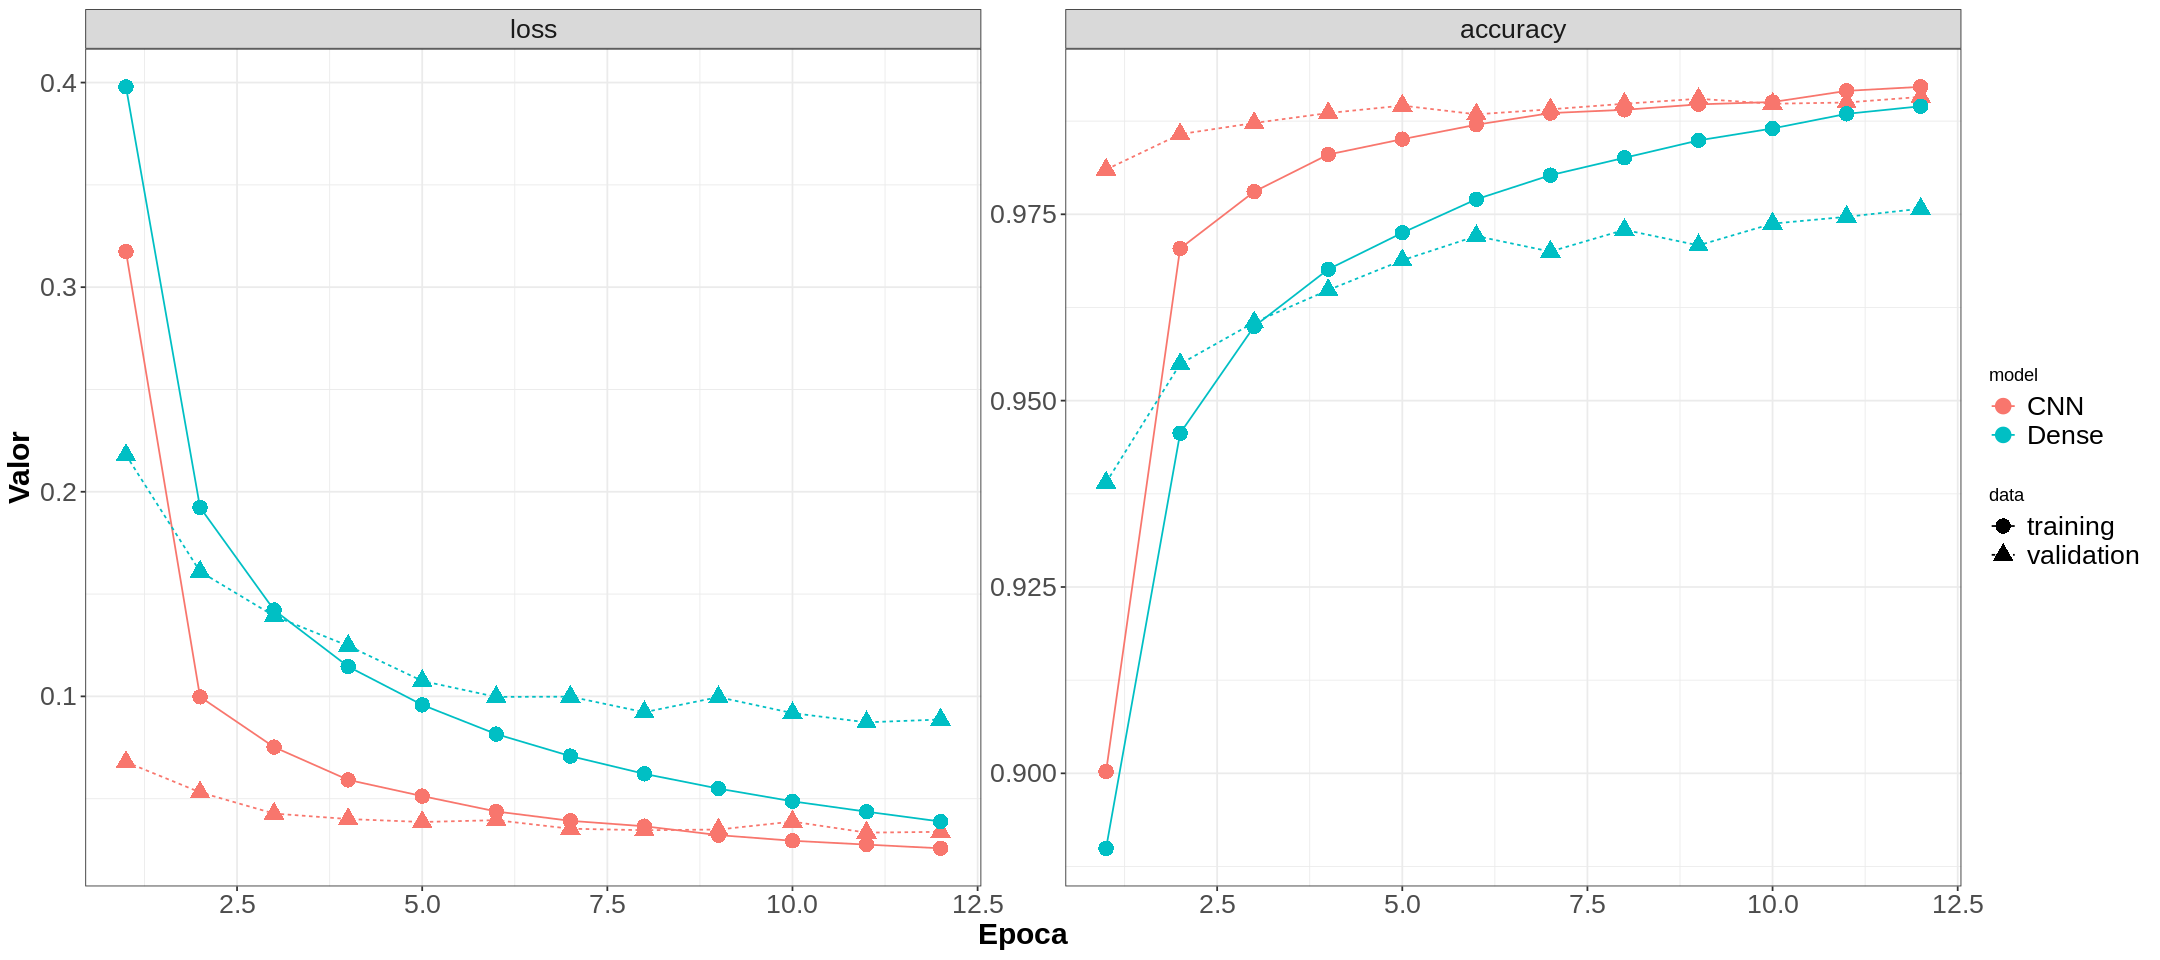

In [44]:
# Plotando as informações juntas, na mesma escala de valores
options(repr.plot.width=18, repr.plot.height=8)
g3 = ggplot(df, aes(x = epoch, y = value, group = algo, colour = model, shape = data, linetype = data)) 
g3 = g3 + geom_line() + geom_point(size=4) + facet_wrap("~metric", scales = "free")
g3 = g3 + theme_bw() + labs(x = "Epoca", y = "Valor")
g3 = g3 + theme(axis.text=element_text(size=16),
        axis.title=element_text(size=18,face="bold"),
        legend.text=element_text(size=16),
        strip.text = element_text(size = 16))
g3

<o que se ve no grafico>

#6. Síntese e considerações finais

No exemplo aqui demonstrado aplicamos uma CNN para realizar uma tarefa de classificação de imagens. O dataset que exploramos foi o MNIST, com imagens originalmente categorizadas em 10 classes distintas. 

Nosso passo a passo de indução e avaliação de um modelo é feito epxlorando as implementações do keras, bilioteca original do Python, mas com pacote disponível que realiza o interfaceamento com R. O fluxo de experimento é o mesmo que seguimos no exemplo 1.

Aqui, nós criamos dois modelos e comparamos suas performances e convergências ao resolver um mesmo problema. Muitas vezes, é também interessante, mensurar o tempo de execução de dois algoritmos, pois, se não há muita diferença na performance dos modelos, podemos escolher o que roda mais rápdio.

Outro detalhe aqui que vocês também já podem ter percebido, é como montar/definir uma arquitetura. Não existe uma regra, geralmente se exploram as arquiteturas existentes na literatura, e posteriomente são feitos pequenos ajustes (inserções de camadas, modificações de funções de ativação, dropouts, etc).

Uma área que tem emergido nos últimos anos é a geração automática dessas arquiteturas (Neural Architeture Search - NAS). Basicamente, são empregadas algumas técnicas de otimização para gerar um número variável de modelos, e escolher o melhor, de forma automatizada. Vale a pena a leitura de artigos da área, caso tenham interesse:

[An Introduction to Neural Architecture Search for CNNs](https://arxiv.org/abs/2005.11074)

Bons estudos :)